In [ ]:
!pip install isodate


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import glob
from datetime import timedelta
from tqdm import tqdm

import requests
import datetime
import tempfile
import re
import pytz
import isodate

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SOOP



### 다시보기 끊겨진거 전처리


In [ ]:
# test
# 파일 경로 설정
# file_path = '241008_13865277_베스트일레본(1+2).txt'
# .txt 파일을 데이터프레임으로 불러오기
# df = pd.read_csv(file_path, sep='\t')  # 탭 구분자 사용 시
# df.head()

In [ ]:
# 파일 경로 설정
path1='/content/drive/MyDrive/SOOP/2월/240208_115693855_이니셜D.txt'
path2='/content/drive/MyDrive/SOOP/2월/240208_115734565_이니셜D.txt'


def read_file(file_path):
  # 파일명에서 date, videoId, title 추출
  file_name = os.path.basename(file_path).replace('.txt', '')  # 확장자 제거
  date_str, videoId, title = file_name.split('_')  # 구분자 '_'로 분리하여 필요한 값 추출

  # '241002' 형식의 date를 '2024-10-02' 형식으로 변환
  date = pd.to_datetime(f'20{date_str}', format='%Y%m%d').strftime('%Y-%m-%d')

  # 빈 리스트를 만들어 각 행을 저장
  data = []

  # 파일 열기 및 내용 추출
  with open(file_path, 'r', encoding='utf-8') as file:
      for line in file:
          # 정규식을 이용해 시간, 닉네임, 아이디, 내용을 추출
          match = re.search(r'\[(.*?)\]\s*(.*?)\((.*?)\):\s*(.*)', line)
          if match:
              time = match.group(1)      # 시간
              nickname = match.group(2)  # 닉네임
              user_id = match.group(3)   # 아이디
              message = match.group(4)   # 내용
              data.append([date, videoId, title, time, nickname, user_id, message])
  # 데이터프레임으로 변환
  df = pd.DataFrame(data, columns=['date', 'videoId', 'title', 'timestamp', 'nickname', 'id', 'content'])
  return df

df1 = read_file(path1)
df2 = read_file(path2)


In [ ]:
df1.head(10)

,date,videoId,title,timestamp,nickname,id,content
0,2024-02-08,115693855,이니셜D,00:00:06,^ㅣ발낙지,njuneimbh,와카
1,2024-02-08,115693855,이니셜D,00:00:08,5143862k,5143862k,왁하
2,2024-02-08,115693855,이니셜D,00:00:09,김뮬,wl1478911,옥하
3,2024-02-08,115693855,이니셜D,00:00:10,밥도둑쓰,wjddml7131,왁하
4,2024-02-08,115693855,이니셜D,00:00:11,종ㅇㅣ학,jkon0902,왁하
5,2024-02-08,115693855,이니셜D,00:00:11,어서오소!,june1310,왁하
6,2024-02-08,115693855,이니셜D,00:00:11,생동이,kimth1130,왁하
7,2024-02-08,115693855,이니셜D,00:00:12,씨비티,jaerm14,왁하
8,2024-02-08,115693855,이니셜D,00:00:12,김뮬,wl1478911,왁하
9,2024-02-08,115693855,이니셜D,00:00:12,엔딜로프,steve96711,왁하


In [ ]:
def timestamp(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  # 시간 덧셈 (예: 06:08:34를 timedelta로 더하기)
  additional_time = timedelta(hours=0,minutes=58, seconds=7)
  df['timestamp'] = df['timestamp'] + additional_time
  df['timestamp'] = df['timestamp'].dt.time
  return df

df2 = timestamp(df2)


<ipython-input-40-88601faeb2d5>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
df = pd.concat([df1, df2])
# .txt 파일로 저장
df.to_csv('/content/drive/MyDrive/SOOP/2월/240208_115693855_이니셜D(1,2).txt', sep='\t', index=False)


In [ ]:
df.head(10)

,date,videoId,title,timestamp,nickname,id,content
0,2024-02-08,115693855,이니셜D,00:00:06,^ㅣ발낙지,njuneimbh,와카
1,2024-02-08,115693855,이니셜D,00:00:08,5143862k,5143862k,왁하
2,2024-02-08,115693855,이니셜D,00:00:09,김뮬,wl1478911,옥하
3,2024-02-08,115693855,이니셜D,00:00:10,밥도둑쓰,wjddml7131,왁하
4,2024-02-08,115693855,이니셜D,00:00:11,종ㅇㅣ학,jkon0902,왁하
5,2024-02-08,115693855,이니셜D,00:00:11,어서오소!,june1310,왁하
6,2024-02-08,115693855,이니셜D,00:00:11,생동이,kimth1130,왁하
7,2024-02-08,115693855,이니셜D,00:00:12,씨비티,jaerm14,왁하
8,2024-02-08,115693855,이니셜D,00:00:12,김뮬,wl1478911,왁하
9,2024-02-08,115693855,이니셜D,00:00:12,엔딜로프,steve96711,왁하


### 월별 데이터 불러오기

In [ ]:

# 폴더 경로 설정
folder_path = '/content/drive/MyDrive/SOOP/5월'

# 폴더 내 모든 .txt 파일 경로를 리스트로 가져오기
file_paths = glob.glob(os.path.join(folder_path, '*.txt'))

# 빈 리스트를 만들어 모든 파일의 데이터를 저장
all_data = []

for file_path in file_paths:
    # 파일명에서 date, videoId, title 추출
    file_name = os.path.basename(file_path).replace('.txt', '')  # 확장자 제거
    date_str, videoId, title = file_name.split('_')  # 구분자 '_'로 분리하여 필요한 값 추출

    # '241002' 형식의 date를 '2024-10-02' 형식으로 변환
    date = pd.to_datetime(f'20{date_str}', format='%Y%m%d').strftime('%Y-%m-%d')

    # 파일 열기 및 내용 추출
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # 정규식 (시간, 닉네임, 아이디, 내용)
            match = re.search(r'\[(.*?)\]\s*(.*?)\((.*?)\):\s*(.*)', line)
            if match:
                time = match.group(1)      # 시간
                nickname = match.group(2)  # 닉네임
                user_id = match.group(3)   # 아이디
                message = match.group(4)   # 내용
                all_data.append([date, videoId, title, time, nickname, user_id, message])

# 리스트를 데이터프레임으로 변환
df = pd.DataFrame(all_data, columns=['date', 'videoId', 'title', 'timestamp', 'nickname', 'id', 'content'])


In [ ]:

print(df['date'].min())
print(df['date'].max())

2024-05-01
2024-05-31


In [ ]:
# 소프트콘 데이터
softcon = pd.read_csv('/content/drive/MyDrive/SOOP/softcon_chat.csv')


## 월별 이모티콘과 일부 키워드 집계


In [ ]:
# timestamp 컬럼에서 날짜를 지정한 날짜로 변경 (시간 부분은 그대로 유지)
df['timestamp'] = df['date'] + ' ' + df['timestamp'].astype(str)


* 이모티콘


In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

In [ ]:
df.groupby(['year','month','day','videoId','title']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,year,month,day,videoId,title,count
26,2024,11,28,143628379,롤+와우,455649
9,2024,11,9,141798881,왁이큐결승,307084
28,2024,11,30,143811175,고멤드림팀(세용),264528
0,2024,11,1,141117401,성별결정법+배구,227436
17,2024,11,21,142957079,롤,222741
13,2024,11,13,142182137,고멤합방(연기의신)+신눕프핵,218543
27,2024,11,29,143717847,이세돌콜라보+고멤드림팀(쵸로키)+롤+와우,211664
22,2024,11,24,143251627,와우+눞프핵,199110
11,2024,11,11,141989273,르르와연애중,198019
24,2024,11,26,143432193,고멤드림팀(소피아),177558


In [ ]:
from tqdm import tqdm
tqdm.pandas()

# 이모티콘 패턴 추출 함수
def extract_emoticons(content):
    # /로 시작해서 /로 끝나는 패턴 추출
    return re.findall(r'/([^/]+)/', content)


# 여러 단어 패턴 추출 함수
def extract_keywords(content, keywords):
    pattern = '|'.join(keywords)
    return re.findall(pattern, content)

# 키워드 리스트

# keywords = ['춘타버스','빅듁','치매','2ㄴ2','이년이','ㅇㄴㅇ','객관안','지지합니다','ㅈㅈㅎㄴㄷ','도황','형태','춘타버스','빅듁','형신','느그']
# df['extracted_keywords'] = df['content'].progress_apply(lambda x: extract_keywords(x, keywords))



In [ ]:
# df의 content 컬럼에서 이모티콘 추출
df['emoticons'] = df['content'].progress_apply(extract_emoticons)


100%|██████████| 4374667/4374667 [00:20<00:00, 213622.33it/s]


In [ ]:
# 빈 리스트가 아닌 데이터만
df_filtered_imoji = df[df['emoticons'].apply(lambda x: len(x) > 0)]
# df_filtered_keyword = df[df['extracted_keywords'].apply(lambda x: len(x) > 0)]

In [ ]:
def et(df, col):
    # date와 emoticon 및 키워드 빈도 계산을 위한 데이터 재구성
    expanded_data = []
    for _, row in df.iterrows():
        date = row['date']
        title = row['title']
        # 키워드 빈도 계산
        if col == 'extracted_keywords':
            for keyword in row['extracted_keywords']:
                expanded_data.append([date, title, keyword])
        # 이모티콘 빈도 계산
        elif col == 'emoticons':
            for emoticon in row['emoticons']:
                expanded_data.append([date, title, emoticon])

    # 새로운 데이터프레임 생성 (날짜별 이모티콘 또는 키워드 빈도 계산용)
    expanded_df = pd.DataFrame(expanded_data, columns=['date', 'title', col])
    expanded_df['month'] = pd.to_datetime(expanded_df['date']).dt.month
    expanded_df['year'] = pd.to_datetime(expanded_df['date']).dt.year
    expanded_df['day'] = pd.to_datetime(expanded_df['date']).dt.day

    # 최종 데이터프레임 반환
    return expanded_df

expanded_df  = et(df_filtered_imoji, 'emoticons')
# expanded_keywords_df = et(df_filtered_keyword,'extracted_keywords')
# month_keyword_cnts = expanded_keywords_df.groupby(['year','month','extracted_keywords']).size().reset_index(name='count').sort_values(by='count', ascending=False)
# # 변경 규칙 정의
# replacement_dict = {
#     '2ㄴ2': '이년이',
#     'ㅇㄴㅇ': '이년이',
#     'ㅈㅈㅎㄴㄷ': '지지합니다'
# }

# # extracted_keywords 컬럼 값을 변경
# month_keyword_cnts['extracted_keywords'] = month_keyword_cnts['extracted_keywords'].replace(replacement_dict)

# # 동일한 키워드를 기준으로 count 합산
# df_grouped = (
#     month_keyword_cnts.groupby(['year', 'month', 'extracted_keywords'], as_index=False)
#     .agg({'count': 'sum'})
#     .sort_values(by='count', ascending=False)  # count 기준 정렬
# )

# df_grouped


In [ ]:
month_keyword_cnt = expanded_df.groupby(['year','month','day','emoticons']).size().reset_index(name='count').sort_values(by='count', ascending=False)
month_keyword_cnt[month_keyword_cnt['emoticons'] =='스키두']

,year,month,day,emoticons,count
1130,2024,11,19,스키두,3086
840,2024,11,12,스키두,938
1017,2024,11,14,스키두,389
932,2024,11,13,스키두,362
770,2024,11,11,스키두,121
470,2024,11,7,스키두,100
339,2024,11,5,스키두,21
543,2024,11,8,스키두,15
122,2024,11,2,스키두,11
190,2024,11,3,스키두,9


## 채팅 속도

In [ ]:
ise_list

[116090033,
 116473113,
 124222959,
 129299295,
 134364119,
 137844119,
 141305601,
 141989273]

In [ ]:

ise = df[df['videoId'].isin(['124222959'])]

# timestamp를 datetime 형식으로 변환
ise['timestamp'] = pd.to_datetime(ise['timestamp'])
# n분 단위로 timestamp 반올림
ise['timestamp_1_Minute'] = ise['timestamp'].dt.floor('1T')

# 각 n분 구간별 채팅 수 집계
chat_counts = ise.groupby(['timestamp_1_Minute', 'title', 'videoId']).size().reset_index(name='count')
# 평균 채팅 수 계산
# avg_chat_counts = chat_counts.groupby(['timestamp_3_Minute','title', 'videoId'])['count'].mean().reset_index(name='average_count')
#
top_5_chat_times = chat_counts.sort_values(by='count', ascending=False).head(100)


<ipython-input-138-aa8085d60d1e>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-138-aa8085d60d1e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-138-aa8085d60d1e>:6: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

<ipython-input-138-aa8085d60d1e>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

* 이세계아이돌 콘텐츠중 가장 채팅이 많이 활성화 되었던 순간은?

* 2024-02-12 01:51:00
* 저세계아이돌 116090033 9552

* 주파수 합방 8066


In [ ]:
ise_list

[116090033,
 116473113,
 124222959,
 129299295,
 134364119,
 137844119,
 141305601,
 141989273]

In [ ]:
# 결과 저장용 DataFrame 생성
result = []

# videoId 별로 처리
for video_id, group in df.groupby('videoId'):
    # timestamp 기준으로 정렬 (필수)
    group = group.sort_values(by='timestamp')

    # 30초 구간별 채팅 수 계산
    window_size = '60S'  # 1분은 '60S'
    # 'on' parameter should be a column name (string), not a Series
    group['chat_count'] = group.rolling(window=window_size, on='timestamp')['timestamp'].count()

    # 해당 videoId의 최대 채팅 수와 구간 찾기
    max_chat_count = group['chat_count'].max()
    peak_window = group[group['chat_count'] == max_chat_count]

    # 결과 저장
    result.append({
        'videoId': video_id,
        'max_chat_count': max_chat_count,
        'start_time': peak_window['timestamp'].min(),
        'end_time': peak_window['timestamp'].max()
    })

# 결과 DataFrame으로 변환
result_df = pd.DataFrame(result)

# result_df


In [ ]:
result_df.sort_values(by=['max_chat_count'])

In [ ]:
# 특정 timestamp의 채팅 수 확인
selected_time = pd.Timestamp("2024-11-28 02:51:25")
window_start = selected_time - pd.Timedelta(seconds=10)

# 해당 구간의 데이터 확인
test = df[df['videoId'] == '143628379']
included_chats = test[(test['timestamp'] >= window_start) & (test['timestamp'] <= selected_time)]
len(included_chats)

6763

In [ ]:
df[(df['videoId'] == '143628379') & (df['timestamp_60sec'] == '2024-11-28 02:51:00')]
# top_5_chat_times

In [ ]:
# 시간 단위로 로그 발생량 집계
# 'T'는 분 단위로 집계 (1분 단위로 그룹화). 'H'는 시간 단위
# time_log_S = df.resample('S', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()
test = ise[ise['videoId']== '116473113']
time_log_T = test.resample('T', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()
# time_log_H = df.resample('H', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()


<ipython-input-125-7c48f68b4276>:5: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [ ]:
import plotly.express as px
# 라인 차트 시각화
fig = px.line(time_log_T, x='timestamp', y='cnt', title='SOOP chat log 저세계아이돌 합방',
              labels={'timestamp': 'Timestamp(hour)', 'cnt': 'Log Count'},
              line_shape='spline') #markers=True

# 시각화 출력
fig.show()

## 시청자별 채팅 통계
* 각 유저들은 몇번씩 채팅을 칠까?
* 가장 많이 채팅을 친 유저는?

* 월별로 시청자별 채팅 집계

In [ ]:
def load_chat(month):
  # 폴더 경로 설정
  folder_path = f'/content/drive/MyDrive/SOOP/{month}월'

  # 폴더 내 모든 .txt 파일 경로를 리스트로 가져오기
  file_paths = glob.glob(os.path.join(folder_path, '*.txt'))

  # 빈 리스트를 만들어 모든 파일의 데이터를 저장
  all_data = []

  for file_path in file_paths:
      # 파일명에서 date, videoId, title 추출
      file_name = os.path.basename(file_path).replace('.txt', '')  # 확장자 제거
      date_str, videoId, title = file_name.split('_')  # 구분자 '_'로 분리하여 필요한 값 추출

      # '241002' 형식의 date를 '2024-10-02' 형식으로 변환
      date = pd.to_datetime(f'20{date_str}', format='%Y%m%d').strftime('%Y-%m-%d')

      # 파일 열기 및 내용 추출
      with open(file_path, 'r', encoding='utf-8') as file:
          for line in file:
              # 정규식 (시간, 닉네임, 아이디, 내용)
              match = re.search(r'\[(.*?)\]\s*(.*?)\((.*?)\):\s*(.*)', line)
              if match:
                  time = match.group(1)      # 시간
                  nickname = match.group(2)  # 닉네임
                  user_id = match.group(3)   # 아이디
                  message = match.group(4)   # 내용
                  all_data.append([date, videoId, title, time, nickname, user_id, message])

  # 리스트를 데이터프레임으로 변환
  df = pd.DataFrame(all_data, columns=['date', 'videoId', 'title', 'timestamp', 'nickname', 'id', 'content'])
  return df


def viewer_static(month):
    # 월 데이터 로드
    df = load_chat(month)
    # 그룹화하여 분석 데이터 생성
    viewer_static = df.groupby(['id', 'date', 'videoId', 'title']).size().reset_index()
    viewer_static.rename(columns={0: 'cnt'}, inplace=True)

    # 분석용 CSV 저장
    file_path = f'/content/drive/MyDrive/SOOP/viewer_static_{month}.csv'
    viewer_static.to_csv(file_path, index=False)

    print(f"CSV 파일이 저장되었습니다: {file_path}")
    return viewer_static

# df = load_chat(6)

# 데이터가 너무 커서 기본 런타임 끊김..
# def generate_viewer_statitcs(df, start_month, end_month):
#     for month in range(start_month, end_month + 1):
#         print(f"{month}월 데이터 처리 중...")
#         viewer_static(df, month)
# generate_viewer_statitcs(df,2,5)


# 월별로 전처리된 시청자 채팅 지표 결합
def concat_viewer_df(start_month, end_month):
    all_data = []
    for month in range(start_month, end_month + 1):
        file_path = f'/content/drive/MyDrive/SOOP/viewer_static_{month}.csv'
        print(f"{month}월 데이터 처리 중...")
        monthly_data = pd.read_csv(file_path, encoding='utf-8')
        all_data.append(monthly_data)
    final_df = pd.concat(all_data, ignore_index= True)
    print("모든 월별 데이터를 병합했습니다.")
    return final_df

view_df = concat_viewer_df(2,13)


2월 데이터 처리 중...
3월 데이터 처리 중...
4월 데이터 처리 중...
5월 데이터 처리 중...
6월 데이터 처리 중...
7월 데이터 처리 중...
8월 데이터 처리 중...
9월 데이터 처리 중...
10월 데이터 처리 중...
11월 데이터 처리 중...
12월 데이터 처리 중...
13월 데이터 처리 중...
모든 월별 데이터를 병합했습니다.


In [ ]:
df = load_chat(12)

* 2월 부터 12월 5일 동안 채팅을 친 유니크한 유저 : 약 118,000 명

In [ ]:
view_df[view_df['id'] == '000294']

In [ ]:
# title 의 type에 문제가 있음..

import unicodedata
# 조합형(NFC)으로 변환하는 함수
def to_composed_form(text):
    return unicodedata.normalize('NFC', text)

# 'title' 컬럼의 모든 제목에 대해 조합형(NFC)으로 변환 적용
view_df['title'] = view_df['title'].apply(to_composed_form)

In [ ]:
# 컨텐츠 카테고리 라벨
mark = '마크|꿈집|왁피스|눕프핵|눞프핵|배틀건콘|해상전쟁'
gomem = '오디션|제3세력|유치원|고멤|아카데미|보물찾기|히키킹|부정형|고백콘|아라포|젠투|성별결정법|물건팔기|데스노트|세돌카드|돚거'
battle = '전국시대|배그삼국지|중간계배그|배그블루밤|전국배그|배그대잔치|배그(버튜버고민상담)|3배|람보르기니|하렘|클랜|공주|크래프톤|배그좀비|배그티어|고민'
sports = '왁체대|사이클|아세토|버축대|왁이큐|체육대회'
zombie = '좀보이드|뱅온전쟁|좀보'
isegye = '이세돌합방|저세계아이돌|르르|이세돌vs버튜버|사슬업|이세돌뮤비|팝업스토어'
fifa = '피파|fc|버축대|베스트일레븐|FC'
song = '구간단속|작캠|워닝소리'



def categorize(df):
    # 새로운 category 컬럼 초기화
    df['category'] = 'etc'

    # 조건별로 category 값 설정
    df.loc[df['title'].str.contains(gomem, na=False), 'category'] = 'gomem'
    df.loc[df['title'].str.contains(mark, na=False), 'category'] = 'mark'
    df.loc[df['title'].str.contains(sports, na=False), 'category'] = 'sports'
    df.loc[df['title'].str.contains(song, na=False), 'category'] = 'song'
    df.loc[df['title'].str.contains(zombie, na=False), 'category'] = 'zomboid'

    df.loc[df['title'].str.contains(battle, na=False) & ~df['title'].str.contains('워닝소리|상콘', na=False), 'category'] = 'battle'
    df.loc[df['title'].str.contains('아르마', na=False) & ~df['title'].str.contains('워닝소리|상콘|악놀|마크|건콘', na=False), 'category'] = 'arma'
    df.loc[df['title'].str.contains('스타', na=False) & ~df['title'].str.contains('워닝소리|상콘|악놀|마크|건콘|아르마|부정형', na=False), 'category'] = 'star'
    df.loc[df['title'].str.contains('아세토', na=False) & ~df['title'].str.contains('배그|워닝소리|상콘|악놀', na=False), 'category'] = 'asseto'
    df.loc[df['title'].str.contains(fifa, na=False) & ~df['title'].str.contains('워닝소리|상콘|악놀|마크|건콘', na=False), 'category'] = 'fifa'
    df.loc[df['title'].str.contains(isegye, na=False) & ~df['title'].str.contains('워닝소리|상콘|악놀|마크|건콘', na=False), 'category'] = 'isegye'

    return df

# 함수 호출
view_df = categorize(view_df)

<ipython-input-6-e3f73596ec12>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df['title'].str.contains(battle, na=False) & ~df['title'].str.contains('워닝소리|상콘', na=False), 'category'] = 'battle'


In [142]:
view_df[view_df['category'] == 'sports'][['title','date','videoId']].value_counts().reset_index().sort_values(by='date', ascending= True) #['videoId'].tolist()


,title,date,videoId,count
0,왁타버스사이클,2024-02-17,116578255,16259
5,상콘+아세토,2024-05-03,123734091,11103
4,아세토+악놀,2024-05-23,125622457,11868
7,왁타버스체육대회공지,2024-07-23,131258123,8869
2,"왁체대(수영,사격)",2024-07-27,131620323,13462
3,"왁체대(달리기,양궁,역도)",2024-07-28,131714125,12110
6,"왁체대(클레이사격,클라이밍)",2024-07-29,131797039,10113
1,"왁체대(장애물달리기,리듬체조,조정)",2024-07-30,131893145,13750
8,버축대중간점검+마크흑백요리사,2024-10-03,138155521,7791
11,고멤드림팀+왁이큐,2024-11-03,141210039,5658


In [ ]:
# view_df['id'] = view_df['id'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", "", x))

In [ ]:
view_df['id'] = view_df['id'].str.replace(r'[^\w\s]', '', regex=True)
view_df['year'] = pd.to_datetime(view_df['date']).dt.year
view_df['month'] = pd.to_datetime(view_df['date']).dt.month

In [ ]:
chat_rnk = view_df.groupby(['id']).agg({'cnt': 'sum'}).sort_values(by='cnt', ascending=False).reset_index()

In [ ]:
# 라벨링 기준 정의
bins = [0, 1000, 10000, 50000, 100000, float('inf')]  # 구간 경계
labels = ['1000 미만', '1000 ~ 10000', '10000 ~ 50000', '50000 ~ 100000', '100000']
# pd.cut을 사용하여 라벨링
chat_rnk['label'] = pd.cut(chat_rnk['cnt'], bins=bins, labels=labels, right=False)

chat_rnk.groupby(['label']).agg({'id': 'count'}).reset_index()


<ipython-input-9-1c7a0dc512ef>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chat_rnk.groupby(['label']).agg({'id': 'count'}).reset_index()


,label,id
0,1000 미만,108391
1,1000 ~ 10000,8238
2,10000 ~ 50000,1484
3,50000 ~ 100000,113
4,100000,27


* 시청자의 대부분은 1000개 미만의 채팅을 친다. (별풍선 도네이션 채팅 포함)
* 채팅도 치는 사람만 계속 치는것을 알 수 있음

In [ ]:
# print(round(chat_rnk['cnt'].mean()))
# print(round(chat_rnk['cnt'].std()))


chat_rnk['cnt'].describe()

,cnt
count,118253.000000
mean,638.773418
std,3999.548337
min,1.000000
25%,2.000000
50%,11.000000
75%,94.000000
max,242686.000000


In [ ]:

# 라벨별 데이터 개수 집계
label_counts = chat_rnk['label'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Chat Count Label Distribution', fontsize=16)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


<ipython-input-40-716f88cfb492>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(zin['check_ratio'], shade=True)  # Use kdeplot for density estimation


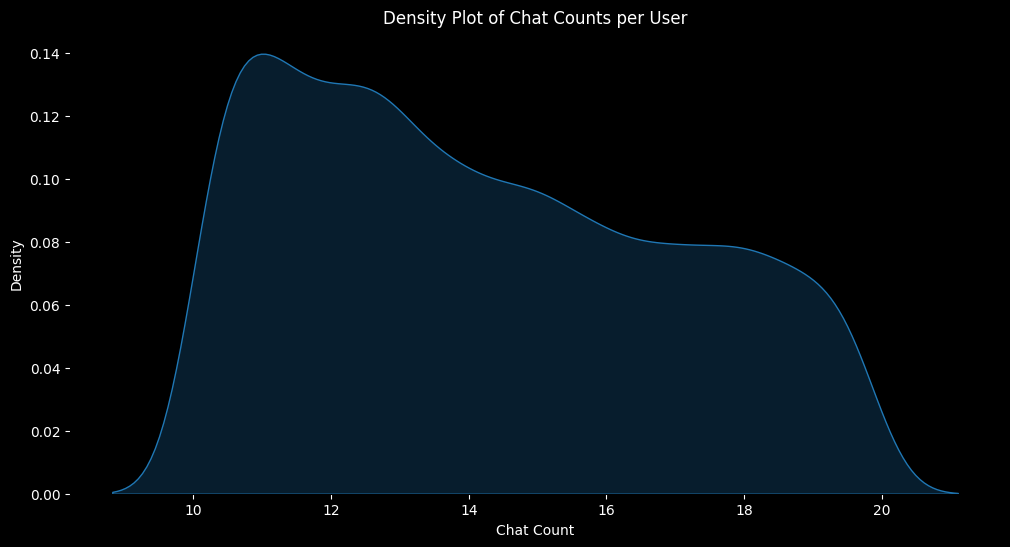

In [ ]:


# Assuming 'chat_rnk' DataFrame is already defined as in your provided code.

user_row = chat_rnk[(chat_rnk['cnt'] > 300) & (chat_rnk['cnt'] < 100000)]

# Create the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(user_row['cnt'], shade=True)  # Use kdeplot for density estimation

plt.title('Density Plot of Chat Counts per User', color='white')
plt.xlabel('Chat Count', color='white')
plt.ylabel('Density', color='white')

# Customize plot elements for better readability
plt.tick_params(colors='white', which='both')
ax = plt.gca()
ax.set_facecolor('black')
plt.gcf().set_facecolor('black')

plt.show()

### 시청자들의 최초 활성화
* 활성화 지표의 기준을 "채팅"을 쳤다라고 보겠습니다.
* 시청자별로 언제 (월별) 처음 채팅을 쳤는지, 즉, 활성화 되었는지 구해보려고 합니다. 어떤 콘텐츠를 했을 때, 새로운 시청자들이 채팅에 참여 했을까요?

In [ ]:
user_by_date = view_df.groupby(['id','date','title','category']).agg({'cnt': 'sum'}).sort_values(by=['id','date'], ascending=False).reset_index()
# user_by_week = view_df.groupby(['id','week_start','title']).agg({'cnt': 'sum'}).sort_values(by=['id','week_start'], ascending=False).reset_index()



In [ ]:
user_by_date.sample(100)

,id,date,title,category,cnt
1046208,gifacin,2024-07-24,"왁굳생일(마크조공,배그)",mark,9
857999,junh53,2024-04-25,워닝소리+아세토,sports,1
298759,sim6721,2024-03-31,왁타버스MT(고멤합방),gomem,2
498683,nur00028,2024-03-14,바로니고멤합방,gomem,1
1391586,11gonggong,2024-10-26,눕프핵3.0,mark,4
...,...,...,...,...,...
1393262,1012039690,2024-05-04,눕프핵,mark,32
368301,rlaeorjs134,2024-02-17,왁타버스사이클,sports,1
736703,ksw2054,2024-03-23,눞프핵+배틀크러쉬(2),mark,24
462885,parkbg8845,2024-02-17,왁타버스사이클,sports,323


In [ ]:
user_by_date_pivot = user_by_date.pivot_table(
    index=['id'],
    columns=['date','category'], # date
    values='cnt',
    aggfunc='sum'
).reset_index().fillna(0)

# 채팅을 한번이라도 남기면 생방송에 참여한것
user_by_date_pivot['check'] = (user_by_date_pivot.iloc[:, 1:] > 0).sum(axis=1)


In [ ]:
user_by_date_pivot.head(100)

date,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-11,2024-02-12,2024-02-13,...,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,2024-12-05,check
category,,mark,fifa,etc,etc,etc,etc,etc,isegye,gomem,...,etc,etc,gomem,gomem,gomem,etc,etc,battle,battle,
0,0000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,000000aa11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,000001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,000009,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,00000oo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0128ara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
96,0129alex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
97,0129wjlee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [ ]:
# multiindex에 해당하는 category를 합산 (채팅수가 아니라 방송 참여여부)
category_check = user_by_date_pivot.iloc[:, 1:-1].groupby(axis=1, level=1).apply(lambda x: (x > 0).sum(axis=1))
for category in category_check.columns:
    user_by_date_pivot[f'{category}'] = category_check[category]

# multiindex에 해당하는 category 제거
user_by_date_pivot.columns = user_by_date_pivot.columns.droplevel(1)
user_by_date_pivot.head()

<ipython-input-13-f24c8aa07fc8>:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  category_check = user_by_date_pivot.iloc[:, 1:-1].groupby(axis=1, level=1).apply(lambda x: (x > 0).sum(axis=1))


date,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-11,2024-02-12,2024-02-13,...,battle,etc,fifa,gomem,isegye,mark,song,sports,star,zomboid
0,0000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,000000aa11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,000001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,000009,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,1,0,1,0,0,0,0
4,00000oo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# user_by_date에서 id별로 가장 높은 cnt 값에 해당하는 title을 구하기
max_title = user_by_date.loc[user_by_date.groupby('id')['cnt'].idxmax(), ['id', 'title','cnt']]
user_by_date_pivot = pd.merge(user_by_date_pivot, max_title, on='id', how='left')
user_by_date_pivot.rename(columns={'cnt': 'max_cnt'}, inplace=True)

In [ ]:
mean_cnt

278

In [ ]:
# 시청자 id , 날짜별 채팅수
id_date_cnt = view_df.groupby(['id','date']).size().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

In [ ]:
# Convert 'cnt' column to numeric type
id_date_cnt['cnt'] = pd.to_numeric(id_date_cnt['cnt'], errors='coerce')

# 시청자들의 첫 채팅
id_date_cnt['date'] = pd.to_datetime(id_date_cnt['date'], errors='coerce')
first_chat_dates = id_date_cnt[id_date_cnt['cnt'] > 0].groupby('id')['date'].min().reset_index()
first_chat_dates.columns = ['id', 'first_chat_date']

# 날짜별 새로운 유저 수 집계
new_user_counts = first_chat_dates.groupby('first_chat_date').size().reset_index(name='new_user_count')

In [ ]:
id_date_cnt

,id,date,cnt
956908,kasawus99,2024-06-26,10
1789175,rukarim,2024-06-26,10
1435706,nkeksk2,2024-06-26,10
1519628,nsweet4220,2024-06-26,10
567355,funo441600,2024-06-26,10
...,...,...,...
801852,insses,2024-11-28,1
801851,insses,2024-11-19,1
801850,insses,2024-11-05,1
801849,insses,2024-10-23,1


고멤들 soop id
#### 고정멤버
> * 뢴트게늄 : jey422
* 해루석 : sangsoak
* 김치만두 : cman0327

####  아카데미
> * 젠투 : wpsxngotek96
* 빅토리 : toryvac
* 쵸로키 : deathhammer

In [ ]:
# 시청자별 chat 참여 횟수, 첫 참여 날짜)
chat_cnt = id_date_cnt.groupby(['id']).agg({'cnt': 'sum','date':'min'}).sort_values(by='cnt', ascending=False).reset_index()
# chat_cnt[chat_cnt['id'].isin(['deathhammer','wpsxngotek96','jey422','toryvac','sangsoak','cman0327'])]



In [ ]:
title_df = view_df.groupby(['date','title']).first().reset_index()[['date','title']]

In [ ]:
# title 정보 결합
new_user_counts.columns = ['date','count']
# Convert 'date' column in title_df to datetime64[ns]
title_df['date'] = pd.to_datetime(title_df['date'])
final_df = pd.merge(new_user_counts, title_df, on='date', how='left')
final_df.sort_values(by='count', ascending=False)

,date,count,title
0,2024-02-04,27322,눕프핵
1,2024-02-05,6034,피파
7,2024-02-12,5776,저세계아이돌
3,2024-02-07,4657,우왁굳을잡아라
109,2024-05-26,2816,악놀콘서트
...,...,...,...
273,2024-11-25,41,컨텐츠짜기
255,2024-11-06,39,데스노트합방+새벽골프
264,2024-11-14,35,휴가전
142,2024-06-27,24,아노하나(다시보기X)


In [ ]:
final_df2 = final_df[final_df['date'] > '2024-02-11']

In [ ]:
# date와 count 기준으로 중복 제거
final_df2 = final_df2.drop_duplicates(subset=['date', 'count'])


In [ ]:
final_df2['month']= pd.to_datetime(final_df2['date']).dt.month

# 월별 최대 유입수와 콘텐츠
month_cnt = final_df2.groupby(['month']).agg(
    total_newbi_cnt = pd.NamedAgg(column='count', aggfunc='sum'),
    max_newbi = pd.NamedAgg(column='count', aggfunc='max')

)
month_cnt['max_title'] = final_df2.loc[
    final_df2.groupby('month')['count'].idxmax(), 'title'
].values


* 컨텐츠 별로 유입되었던 시청자들 수는?

어떤 콘텐츠로 나눠야하나..


In [ ]:
# 이세계 아이돌

final_df2[final_df2['title'].str.contains('저세계아이돌|이세돌팝업|이세돌뮤비|이세돌vs버튜버|이세돌커버곡|이세돌합방')]['count'].sum()

8471

In [ ]:
# 컨텐츠명 (포함단어)에 따른 시청자 유입수 집계
def count (df,title):
  return df[df['title'].str.contains(title)]['count'].sum()


# 마인크래프트 월별 유동수
# maine = final_df2[final_df2['title'].str.contains('눞프핵|눕프핵|마크|꿈집')].groupby(['month']).agg(
#     cnt = pd.NamedAgg(column='count', aggfunc='sum')
# ).reset_index()
# maine

In [ ]:
# final_df2[(final_df2['title'].str.contains(battle)) & (~final_df2['title'].str.contains('워닝소리|상콘'))].sort_values(by=['count'])
final_df2[(final_df2['title'].str.contains(mark))].sort_values(by=['count'])

,date,count,title,month
263,2024-11-13,68,고멤합방(연기의신)+신눕프핵,11
242,2024-10-26,70,눕프핵3.0,10
157,2024-07-16,79,꿈집견자희상담+배그,7
219,2024-09-29,83,배틀눕프핵,9
215,2024-09-22,86,배틀건콘맵+고멤집+fc,9
158,2024-07-17,89,배그+마크꿈의집(견자희),7
114,2024-06-01,94,왁피스만들기,6
258,2024-11-08,97,포켓몬카드게임+마크계급장,11
108,2024-05-25,108,눞프핵,5
163,2024-07-24,108,"왁굳생일(마크조공,배그)",7


In [ ]:
# 왁타버스 vrchat 컨텐츠 (왁타버스사이클,제3세력,)
print('배그' , final_df2[(final_df2['title'].str.contains(battle)) & (~final_df2['title'].str.contains('워닝소리|상콘'))]['count'].sum())
print('마크',final_df2[(final_df2['title'].str.contains(mark))]['count'].sum())
print('아르마', final_df2[(final_df2['title'].str.contains('아르마')) & (~final_df2['title'].str.contains('워닝소리|상콘|악놀|마크|건콘'))]['count'].sum())
print('스타', final_df2[(final_df2['title'].str.contains('스타')) & (~final_df2['title'].str.contains('워닝소리|상콘|악놀|마크|건콘|아르마|부정형'))]['count'].sum())
print('아세토',final_df2[(final_df2['title'].str.contains('아세토')) & (~final_df2['title'].str.contains('배그|워닝소리|상콘|악놀'))]['count'].sum())
print('피파',final_df2[(final_df2['title'].str.contains(fifa)) & (~final_df2['title'].str.contains('워닝소리|상콘|악놀|마크|건콘'))]['count'].sum())
print('이세계',final_df2[(final_df2['title'].str.contains(isegye)) & (~final_df2['title'].str.contains('워닝소리|상콘|악놀|마크|건콘'))]['count'].sum())


배그 6104
마크 5274
아르마 3137
스타 2984
아세토 2530
피파 1516
이세계 8195


<ipython-input-32-0a51063f3760>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print('배그' , final_df2[(final_df2['title'].str.contains(battle)) & (~final_df2['title'].str.contains('워닝소리|상콘'))]['count'].sum())


In [ ]:
final_df2[(final_df2['title'].str.contains(isegye)) & (~final_df2['title'].str.contains('워닝소리|상콘|악놀|마크|건콘'))]

,date,count,title,month
7,2024-02-12,5776,저세계아이돌,2
12,2024-02-16,1015,이세돌팝업스토어+챗지피티,2
91,2024-05-08,572,이세돌vs버튜버+사슴똥겜,5
146,2024-07-02,226,사슬업(고멤vs이세돌),7
190,2024-08-25,312,이세돌합방(주파수게임)+릴파신곡,8
220,2024-09-30,90,이세돌합방+FC야간반,9
253,2024-11-04,115,이세돌뮤비모집,11
261,2024-11-11,89,르르와연애중,11


In [ ]:
view_df

,id,date,videoId,title,cnt,year,month
0,lost270801,2024-02-05,115440421,피파,3,2024,2
1,sharkbread,2024-02-09,115809805,기획+이세돌노가리,1,2024,2
2,chlwndyd761,2024-02-29,117726535,아르마+스타,4,2024,2
3,gkdl917,2024-02-12,116090033,저세계아이돌,3,2024,2
4,jsoo6624,2024-02-21,116966845,배그뽑기,1,2024,2
...,...,...,...,...,...,...,...
2453256,하위beagch00,2024-02-25,117337253,배그삼국지(1),15,2024,2
2453257,하위beagch00,2024-02-25,117350245,배그삼국지(2),14,2024,2
2453258,하태양gkhhjrio123,2024-02-14,116286877,LCK+조편성(2),1,2024,2
2453259,한강단신풍dangisio1199,2024-02-25,117337253,배그삼국지(1),1,2024,2


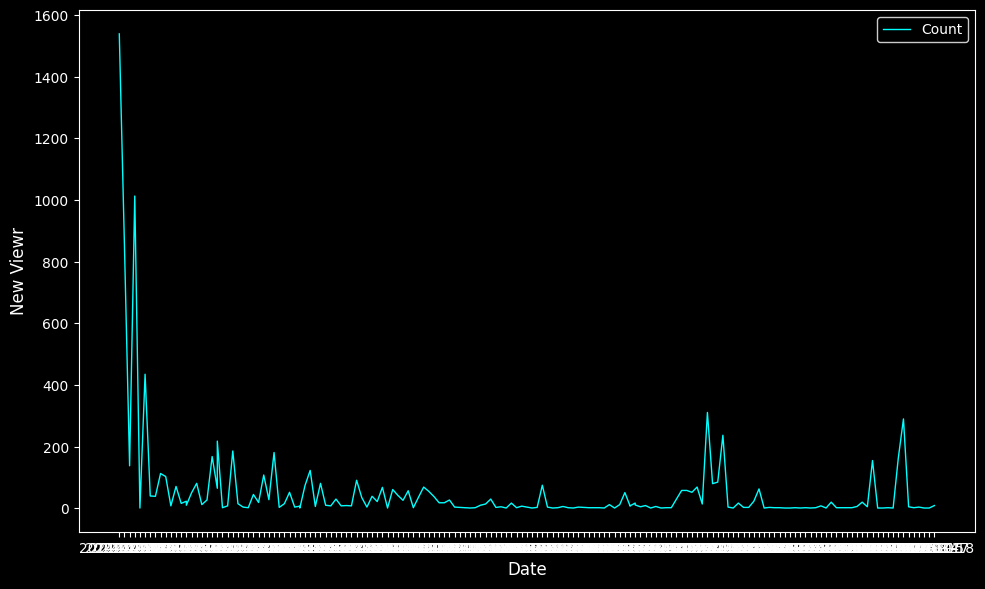

In [ ]:
# 날짜를 datetime 형식으로 변환
# 날짜순으로 정렬
final_df = final_df.sort_values(by='date')
rows = view_df[view_df['id'] == '103279'].sort_values(by='date')
# 스타일 설정: 검은색 배경
plt.style.use('dark_background')

# 라인 차트 생성
plt.figure(figsize=(10, 6))
plt.plot(rows['date'], rows['cnt'], linestyle='-', color='cyan', linewidth=1, label='Count')

# 차트 제목 및 축 레이블 설정
# plt.title('Date vs Count Line Chart', fontsize=16, color='white')
plt.xlabel('Date', fontsize=12)
plt.ylabel('New Viewr', fontsize=12)
plt.xticks(rotation=0, color='white')
plt.legend(facecolor='black', edgecolor='white')

# 차트 표시
plt.tight_layout()
plt.show()

* 아무래도 2월에 공식적인 SOOP 컴백데뷔를 하셨다보니 당연히 2월에 가장 많은 것을 볼 수 있습니다.
* 2월을 제거하고 본다면, 악놀콘서트, 악놀, 스타생컨, 구간단속, 배그대잔치 순으로 유입이 많이 된것을 볼 수 있었습니다.

### 시청자들의 출석률

In [ ]:
len(user_by_date_pivot) # 고유 시청자수

118253

In [ ]:
# 264일, 45주, 방송
user_by_date_pivot['live'] = 264
user_by_date_pivot['check_ratio'] = user_by_date_pivot['check'] * 100 / user_by_date_pivot['live']

* 총 264일 방송을 했음

In [ ]:
# prompt: 모든 컬럼을 보이게 해줘

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# prompt: pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# 위 설정을 취소해줘

# pd.reset_option('display.max_rows')

In [ ]:
royal_user = user_by_date_pivot[user_by_date_pivot['check_ratio']>=99].sort_values(by='check_ratio', ascending=False)
# royal_user.to_csv('/content/drive/MyDrive/SOOP/royal_user.csv')


royal_user

date,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-11,2024-02-12,2024-02-13,...,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,2024-12-05,check,live,check_ratio
6466,apuc1137,577.0,124.0,257.0,498.0,180.0,249.0,93.0,802.0,392.0,...,441.0,783.0,366.0,277.0,420.0,774.0,833.0,264,264,100.000000
36968,hp4258,477.0,455.0,237.0,649.0,185.0,532.0,35.0,815.0,353.0,...,228.0,387.0,373.0,185.0,165.0,557.0,591.0,264,264,100.000000
11947,ccc2696,104.0,14.0,27.0,76.0,10.0,21.0,13.0,37.0,75.0,...,20.0,57.0,13.0,32.0,23.0,44.0,34.0,264,264,100.000000
67869,nameu0317,1711.0,954.0,416.0,949.0,131.0,9.0,112.0,688.0,676.0,...,183.0,101.0,103.0,60.0,111.0,264.0,440.0,264,264,100.000000
75114,nshawn1103,566.0,365.0,324.0,574.0,143.0,290.0,82.0,490.0,360.0,...,364.0,474.0,444.0,165.0,219.0,420.0,582.0,264,264,100.000000
99480,tdnpqxns8,227.0,82.0,93.0,97.0,75.0,204.0,19.0,68.0,151.0,...,93.0,120.0,71.0,31.0,86.0,151.0,145.0,264,264,100.000000
27596,fkdlsrmfls1,816.0,835.0,493.0,1046.0,247.0,15.0,97.0,621.0,646.0,...,37.0,461.0,340.0,19.0,319.0,94.0,152.0,264,264,100.000000
56937,ksw4312,173.0,9.0,2.0,21.0,40.0,27.0,42.0,278.0,45.0,...,25.0,73.0,34.0,65.0,11.0,41.0,20.0,264,264,100.000000
35373,hhotsixx,455.0,531.0,443.0,1044.0,140.0,394.0,67.0,652.0,549.0,...,392.0,333.0,498.0,254.0,270.0,419.0,642.0,264,264,100.000000
89475,samsung1988,182.0,176.0,180.0,253.0,75.0,107.0,10.0,158.0,113.0,...,69.0,49.0,16.0,86.0,22.0,85.0,23.0,264,264,100.000000


* 가령 000000aa11 유저의 경우 딱 한번 채팅에 참여했는데, 이는 고멤컨텐츠가 있던날 (출석률은 0.38%)
* 유동일 확률이 높다.

In [ ]:
user_by_date_pivot.head()

date,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-11,2024-02-12,2024-02-13,...,fifa,gomem,isegye,mark,song,sports,star,zomboid,live,check_ratio
0,0000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,264,0.378788
1,000000aa11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,264,0.378788
2,000001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,264,0.378788
3,000009,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,1,0,0,0,0,264,1.515152
4,00000oo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,264,0.378788


* 방송 출석체크 분포

In [ ]:
rows = user_by_date_pivot[user_by_date_pivot['check_ratio'] >= 10].sort_values(by='check_ratio', ascending=False)

# print(len(user_by_date_pivot))
print(len(rows))
# print(len(user_by_date_pivot) - len(rows))

20831


* 출석률이 5.3 이하인 시청자수가 75%

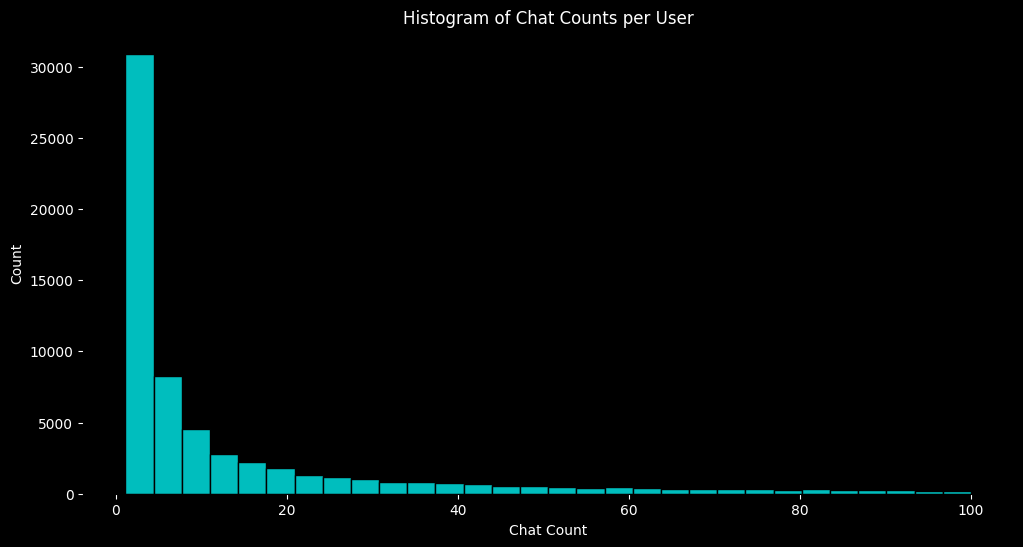

In [ ]:
rows = user_by_date_pivot[user_by_date_pivot['check_ratio'] >= 1].sort_values(by='check_ratio', ascending=False)

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(rows['check_ratio'], bins=30, color='cyan', kde=False)  # bins는 막대 개수, kde=False로 밀도 비활성화

# Customize the plot
plt.title('Histogram of Chat Counts per User', color='white')
plt.xlabel('Chat Count', color='white')
plt.ylabel('Count', color='white')

# Set plot aesthetics for better readability
plt.tick_params(colors='white', which='both')
ax = plt.gca()
ax.set_facecolor('black')  # Background color for the plot
plt.gcf().set_facecolor('black')  # Background color for the figure

# Show the plot
plt.show()

### 시정차 RETENTION 구하기
* 매일 방송을 하는 것이 아니기 때문에 month retention 을 구하기로 결정

In [ ]:
view_df

In [ ]:
# date 컬럼을 datetime으로 변환하고 week 정보 추가
view_df['date'] = pd.to_datetime(view_df['date'])
view_df['week'] = view_df['date'] - pd.to_timedelta(view_df['date'].dt.dayofweek, unit='d')

# chat_cnt table : 시청자별 출석(채팅참여) 횟수 와 첫 채팅 날짜
view_df['first_chat_week'] = view_df.groupby('id')['week'].transform('min').dt.to_period('W').dt.to_timestamp()
view_df['first_chat_month'] = view_df.groupby('id')['month'].transform('min')

In [ ]:
retention_11 = view_df[view_df['month'] < 12]

In [ ]:
def retention(df, retention_type):
    if retention_type == 'week':
        # 주 차이 계산 (14일 차이 -> 14/7 -> 2주)
        df['week_diff'] = ((df['week'] - df['first_chat_week']).dt.days // 7).astype(int)

        # Pivot 테이블을 사용하여 각 주 별 고객 수 계산
        retention_df = df.pivot_table(
            index='first_chat_week',
            columns='week_diff',
            values='id',
            aggfunc=lambda x: x.nunique()  # COUNT(DISTINCT id)
        ).fillna(0).astype(int)

        # 결과 정리
        retention_df.columns = [f'week{i}' for i in retention_df.columns]  # 컬럼 이름 변경
        retention_df.reset_index(inplace=True)

    elif retention_type == 'month':
        # 월 차이 계산 (month - first_chat_month)
        df['month_diff'] = (df['month'] - df['first_chat_month'])
        # Pivot 테이블을 사용하여 각 월별 고객 수 계산
        retention_df = df.pivot_table(
            index='first_chat_month',
            columns='month_diff',
            values='id',
            aggfunc=lambda x: x.nunique()  # COUNT(DISTINCT id)
        ).fillna(0).astype(int)

        # 결과 정리
        retention_df.columns = [f'month{i}' for i in retention_df.columns]  # 컬럼 이름 변경
        retention_df.reset_index(inplace=True)

    return retention_df

retention_df = retention(retention_11, retention_type ='month')

<ipython-input-142-d2ed9212bed9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_diff'] = (df['month'] - df['first_chat_month'])


* 월별 리텐션

In [ ]:
retention_df

,first_chat_month,month0,month1,month2,month3,month4,month5,month6,month7,month8,month9
0,2,66528,50.858285,41.956770,47.118506,34.908610,34.562891,33.940596,31.352213,30.578102,26.518158
1,3,10525,31.078385,34.156770,21.862233,19.923990,20.009501,17.976247,17.871734,14.441805,0.000000
2,4,5855,39.965841,21.742101,20.119556,19.163108,17.045260,16.618275,13.458582,0.000000,0.000000
3,5,12809,18.494808,14.364900,13.919900,12.514638,11.741744,8.978062,0.000000,0.000000,0.000000
4,6,4210,25.558195,20.308789,17.600950,15.368171,11.828979,0.000000,0.000000,0.000000,0.000000
5,7,3848,33.160083,24.350312,20.971933,15.930353,0.000000,0.000000,0.000000,0.000000,0.000000
6,8,4296,26.303538,18.272812,13.989758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,9,3636,24.477448,15.649065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,10,3623,24.013249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,11,2411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# 첫 번째(주.월) 기준으로 나머지 주차들을 리텐션 비율로 변환
for month in range(0, 10):  # month1부터 month10까지
    month_col = f"month{month}"
    # month0 값은 100%가 아니라 실제 사용자 수여야 하므로 이를 기준으로 리텐션 비율 계산
    retention_df[month_col] = (retention_df[month_col] / retention_df["month0"]) * 100

# 결과 확인
retention_df


,first_chat_month,month0,month1,month2,month3,month4,month5,month6,month7,month8,month9
0,2,100.0,50.858285,41.956770,47.118506,34.908610,34.562891,33.940596,31.352213,30.578102,26.518158
1,3,100.0,31.078385,34.156770,21.862233,19.923990,20.009501,17.976247,17.871734,14.441805,0.000000
2,4,100.0,39.965841,21.742101,20.119556,19.163108,17.045260,16.618275,13.458582,0.000000,0.000000
3,5,100.0,18.494808,14.364900,13.919900,12.514638,11.741744,8.978062,0.000000,0.000000,0.000000
4,6,100.0,25.558195,20.308789,17.600950,15.368171,11.828979,0.000000,0.000000,0.000000,0.000000
5,7,100.0,33.160083,24.350312,20.971933,15.930353,0.000000,0.000000,0.000000,0.000000,0.000000
6,8,100.0,26.303538,18.272812,13.989758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,9,100.0,24.477448,15.649065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,10,100.0,24.013249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,11,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
retention_df[retention_df['first_chat_month'] == 2  ]

,first_chat_month,month0,month1,month2,month3,month4,month5,month6,month7,month8,month9
0,2,100.0,50.858285,41.95677,47.118506,34.90861,34.562891,33.940596,31.352213,30.578102,26.518158


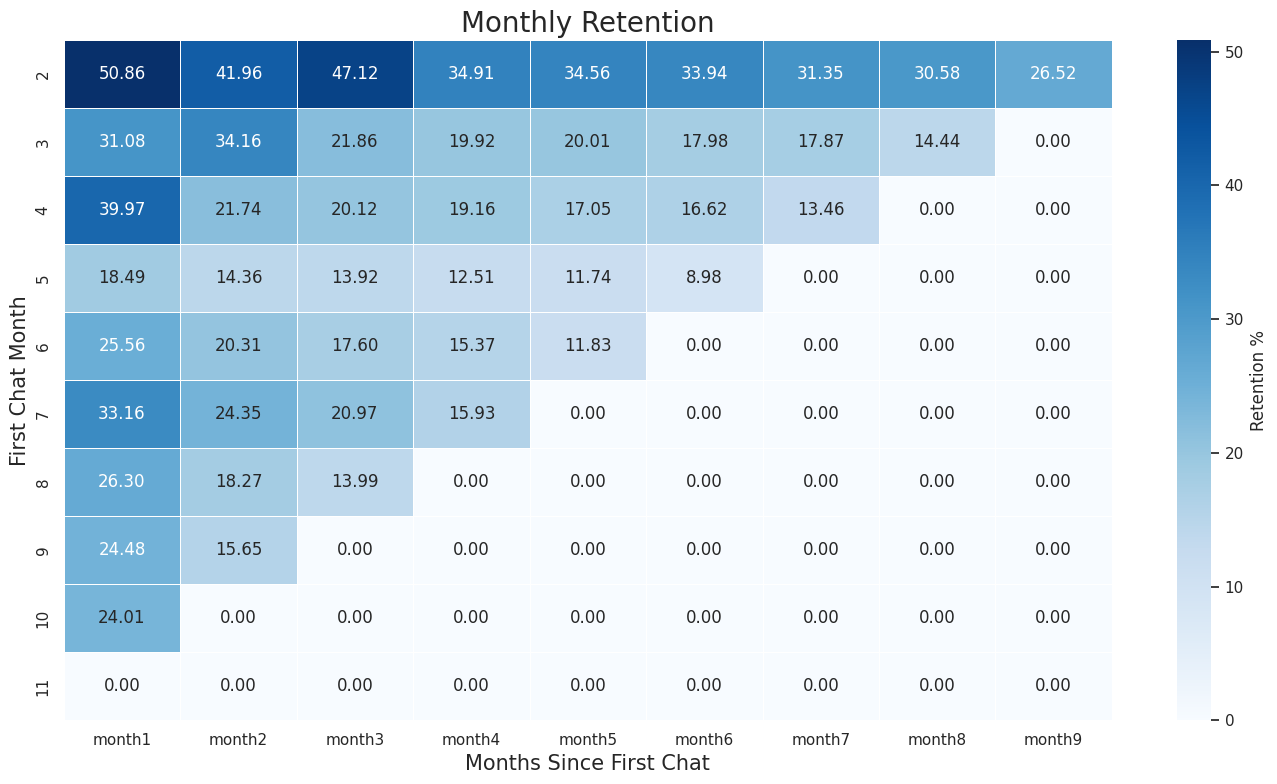

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_monthly_retention(retention_df):
    # 그래프 크기 설정
    plt.figure(figsize=(14, 8))

    # 월별 리텐션 시각화
    sns.set(style="whitegrid")
    retention_df = retention_df.drop(columns=['month0'])

    # 히트맵을 사용하여 시각화
    retention_matrix = retention_df.set_index('first_chat_month') # drop removed

    # 히트맵 그리기
    ax = sns.heatmap(
        retention_matrix,
        annot=True,
        fmt='.2f',
        cmap='Blues',  # 색상 설정
        linewidths=0.5,
        cbar_kws={'label': 'Retention %'},  # 컬러바 라벨
        # vmin=0, vmax=100  # 비율의 범위 설정
    )

    # 차트 제목과 레이블 설정
    plt.title('Monthly Retention', fontsize=20)
    plt.xlabel('Months Since First Chat', fontsize=15)
    plt.ylabel('First Chat Month', fontsize=15)

    # 차트 표시
    plt.tight_layout()
    plt.show()

# retention_df는 제공된 형태의 데이터프레임이어야 합니다.
plot_monthly_retention(retention_df)


* 2월 유입수 기준 3개월 뒤인 5월에 오히려 리텐션이 증가했는데 어떤 콘텐츠를 진행한걸까?
* 악어의 놀이터, 이세돌vs버튜버, 배그대잔치, 구간단속, 고백콘서트, 여목찾 등 컨텐츠가 겹치는게 없는 혜자의 날이었음

In [ ]:
# 첫번째(주.월) 기준으로 나머지 주차들을 리텐션 비율로 변환
for week in range(1, 45):  # week1부터 week44까지
    week_col = f"week{week}"
    retention_df[week_col] = (retention_df[week_col] / retention_df["week0"]) * 100

In [ ]:
retention_df

## 시청자별 세그먼트 나누기

* 1~20  
* 20~40
* 40~60
* 60~80
* 80

In [ ]:
# 전체 컨텐츠 수

total_values = {
    'arma': 8,
    'asseto': 13,
    'battle': 22,
    'etc': 84,
    'fifa': 9,
    'gomem': 55,
    'isegye': 8,
    'mark': 27,
    'song': 13,
    'sports': 13,
    'star': 7,
    'zomboid': 5
}

# 'total_*' 컬럼 추가
for category, total in total_values.items():
    user_by_date_pivot[f'total_{category}'] = total

categories = ['arma', 'asseto', 'battle', 'etc', 'fifa', 'gomem', 'isegye', 'mark', 'song', 'sports', 'star', 'zomboid']

# 각 카테고리별로 비율을 계산하여 'ratio' 컬럼 추가
for category in categories:
    user_by_date_pivot[f'{category}_ratio'] = round((user_by_date_pivot[category] / user_by_date_pivot[f'total_{category}']) * 100,2)



* 출석률 10% 미만인 시청자중 딱 한번 채팅을 친 시청자가 50% 해당함
* 대부분은 유동이라고 파악됨
* 출석률 분포도 그래프에서 격차가 완만해지는 지점 +  유동러의 존재를 고려하여 출석률 10% 이상인 시청자들을 기준으로 세그먼트를 나누기로 결정

In [ ]:
user_by_date_pivot

,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-11,2024-02-12,2024-02-13,...,battle_ratio,etc_ratio,fifa_ratio,gomem_ratio,isegye_ratio,mark_ratio,song_ratio,sports_ratio,star_ratio,zomboid_ratio
0,0000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,11.11,0.00,0.0,0.0,0.00,0.0,0.00,0.0
1,000000aa11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,1.82,0.0,0.0,0.00,0.0,0.00,0.0
2,000001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.19,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0
3,000009,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.55,0.00,11.11,1.82,0.0,3.7,0.00,0.0,0.00,0.0
4,00000oo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.19,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118248,하위beagch00,54.0,0.0,7.0,170.0,0.0,32.0,1.0,50.0,0.0,...,22.73,13.10,0.00,5.45,12.5,3.7,7.69,0.0,42.86,0.0
118249,하태양gkhhjrio123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.19,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0
118250,한강단신풍dangisio1199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.55,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0
118251,한섭shtjddls1gh,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.19,0.00,5.45,0.0,3.7,0.00,0.0,14.29,0.0


In [ ]:
# 출석률이 10% 이상인 시청자들
user_by_date_pivot_10 = user_by_date_pivot[user_by_date_pivot['check_ratio'] >= 10]


# 라벨링 기준 정의
bins = [10, 20, 40, 60, 80, float('inf')]  # 구간 경계
labels = ['10 ~ 20', '20 ~ 40', '40 ~ 60', '60 ~ 80' , '80 이상']
# pd.cut을 사용하여 라벨링
user_by_date_pivot_10['label'] = pd.cut(user_by_date_pivot_10['check_ratio'], bins=bins, labels=labels, right=False)

user_by_date_pivot_10.groupby(['label']).agg({'id': 'count'}).reset_index()


<ipython-input-23-1719d6002288>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_by_date_pivot_10['label'] = pd.cut(user_by_date_pivot_10['check_ratio'], bins=bins, labels=labels, right=False)
<ipython-input-23-1719d6002288>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_by_date_pivot_10.groupby(['label']).agg({'id': 'count'}).reset_index()


,label,id
0,10 ~ 20,7621
1,20 ~ 40,6368
2,40 ~ 60,3178
3,60 ~ 80,2132
4,80 이상,1532


In [155]:
royar = user_by_date_pivot_10[user_by_date_pivot_10['check_ratio'] == 100].sort_values(by=['check'], ascending= False).iloc[:, :-42]
chat_columns = [col for col in royar.columns if col != 'id' and col != 'check']

# id별로 평균 채팅 수 계산
royar['average_chat_cnt'] = royar[chat_columns].mean(axis=1)
royar

,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-11,2024-02-12,2024-02-13,...,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,2024-12-05,check,average_chat_cnt
6466,apuc1137,577.0,124.0,257.0,498.0,180.0,249.0,93.0,802.0,392.0,...,398.0,441.0,783.0,366.0,277.0,420.0,774.0,833.0,264,450.897727
11947,ccc2696,104.0,14.0,27.0,76.0,10.0,21.0,13.0,37.0,75.0,...,30.0,20.0,57.0,13.0,32.0,23.0,44.0,34.0,264,30.814394
27596,fkdlsrmfls1,816.0,835.0,493.0,1046.0,247.0,15.0,97.0,621.0,646.0,...,498.0,37.0,461.0,340.0,19.0,319.0,94.0,152.0,264,472.303030
35373,hhotsixx,455.0,531.0,443.0,1044.0,140.0,394.0,67.0,652.0,549.0,...,734.0,392.0,333.0,498.0,254.0,270.0,419.0,642.0,264,407.871212
36968,hp4258,477.0,455.0,237.0,649.0,185.0,532.0,35.0,815.0,353.0,...,230.0,228.0,387.0,373.0,185.0,165.0,557.0,591.0,264,367.185606
56937,ksw4312,173.0,9.0,2.0,21.0,40.0,27.0,42.0,278.0,45.0,...,39.0,25.0,73.0,34.0,65.0,11.0,41.0,20.0,264,81.325758
67869,nameu0317,1711.0,954.0,416.0,949.0,131.0,9.0,112.0,688.0,676.0,...,401.0,183.0,101.0,103.0,60.0,111.0,264.0,440.0,264,298.526515
75114,nshawn1103,566.0,365.0,324.0,574.0,143.0,290.0,82.0,490.0,360.0,...,420.0,364.0,474.0,444.0,165.0,219.0,420.0,582.0,264,267.458333
89475,samsung1988,182.0,176.0,180.0,253.0,75.0,107.0,10.0,158.0,113.0,...,246.0,69.0,49.0,16.0,86.0,22.0,85.0,23.0,264,76.825758
99480,tdnpqxns8,227.0,82.0,93.0,97.0,75.0,204.0,19.0,68.0,151.0,...,154.0,93.0,120.0,71.0,31.0,86.0,151.0,145.0,264,114.522727


In [ ]:
user_by_date_pivot[user_by_date_pivot['id'] =='njisun0521' ][['id','check','check_ratio']]

date,id,check,check_ratio
71468,njisun0521,30,11.363636


In [ ]:
user_by_date_pivot_10.sample(100)[['id','check_ratio','label']]

date,id,check_ratio,label
71468,njisun0521,11.363636,10 ~ 20
23002,dororong0303,26.136364,20 ~ 40
96010,spinel0724,26.515152,20 ~ 40
104580,trlatjdtn400,82.196970,80 이상
36960,hozzaang,16.287879,10 ~ 20
...,...,...,...
81234,pororyu,26.893939,20 ~ 40
92835,sio4830,31.060606,20 ~ 40
78282,orangechicke,13.257576,10 ~ 20
95391,sonia9157,57.196970,40 ~ 60


In [ ]:
zin = user_by_date_pivot_10[user_by_date_pivot_10['label'] == '10 ~ 20'] #.sort_values(by='check_ratio')
bird = user_by_date_pivot_10[user_by_date_pivot_10['label'] == '20 ~ 40'] #.sort_values(by='check_ratio')
panch = user_by_date_pivot_10[user_by_date_pivot_10['label'] == '40 ~ 60'] #.sort_values(by='check_ratio')
lion = user_by_date_pivot_10[user_by_date_pivot_10['label'] == '60 ~ 80'] #.sort_values(by='check_ratio')
wakreet =  user_by_date_pivot_10[user_by_date_pivot_10['label'] == '80 이상'] #.sort_values(by='check_ratio')



* 세그먼트 별로 어떤 콘텐츠를 진행하는 날에 주로 채팅을 참여하는지

In [ ]:
wakreet[['etc_ratio',	'gomem_ratio',	'mark_ratio',	'battle_ratio',	'sports_ratio',	'fifa_ratio','song_ratio','isegye_ratio'	,'asseto_ratio','zomboid_ratio']].describe() #.sample(10)

,etc_ratio,gomem_ratio,mark_ratio,battle_ratio,sports_ratio,fifa_ratio,song_ratio,isegye_ratio,asseto_ratio,zomboid_ratio
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,86.348368,89.718577,90.480392,92.738466,91.841906,91.232226,92.936469,91.457245,91.660933,87.545692
std,7.280490,7.457354,7.931800,7.117919,9.492170,12.682638,8.461839,10.554219,11.019938,17.823648
min,65.480000,61.820000,55.560000,59.090000,38.460000,11.110000,53.850000,50.000000,23.080000,20.000000
25%,80.950000,85.450000,85.190000,89.772500,84.620000,88.890000,84.620000,87.500000,84.620000,80.000000
50%,86.900000,90.910000,92.590000,95.450000,92.310000,100.000000,92.310000,100.000000,92.310000,100.000000
75%,91.670000,96.360000,96.300000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000




 출석률 80% 이상에 해당하는 왁크리트 집단의 경우
* 어떤 콘텐츠에 편향되지 않고 평균적으로 모두 80% 이상의 참여도를 보여주고 있다.
* 다만, fifa, asseto, zomboid 의 참여도 표준편차가 상대적으로 컸음

### 세그먼트별 검정


In [ ]:
from scipy.stats import shapiro

# 콘텐츠별 출석률 컬럼만 선택
columns = ['etc_ratio', 'gomem_ratio', 'mark_ratio', 'battle_ratio',
           'sports_ratio', 'fifa_ratio', 'song_ratio', 'isegye_ratio',
           'asseto_ratio', 'zomboid_ratio']

content_ratios = wakreet[columns]

In [ ]:
content_ratios

,etc_ratio,gomem_ratio,mark_ratio,battle_ratio,sports_ratio,fifa_ratio,song_ratio,isegye_ratio,asseto_ratio,zomboid_ratio
30,86.90,80.00,92.59,90.91,84.62,100.00,100.00,87.5,92.31,60.0
44,86.90,89.09,88.89,95.45,76.92,88.89,100.00,87.5,92.31,100.0
319,94.05,90.91,96.30,100.00,100.00,100.00,100.00,87.5,92.31,80.0
355,95.24,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.0
357,80.95,81.82,85.19,86.36,76.92,88.89,92.31,100.0,69.23,80.0
...,...,...,...,...,...,...,...,...,...,...
117072,98.81,92.73,96.30,100.00,92.31,100.00,92.31,87.5,100.00,100.0
117105,90.48,90.91,88.89,95.45,84.62,88.89,76.92,100.0,84.62,60.0
117453,90.48,96.36,88.89,90.91,92.31,100.00,100.00,100.0,100.00,80.0
117572,82.14,89.09,100.00,90.91,92.31,100.00,92.31,100.0,100.00,100.0


모든 세그먼트 정규성 검정 만족

In [ ]:

from scipy.stats import shapiro

# 분포들의 정규성검정
def skew_kurt(df):
    skewness = df['check_ratio'].skew()
    kurtosis = df['check_ratio'].kurt()

    print(f"Skewness : {skewness}") # 0.3으로 대칭에 가깝다.
    print(f"Kurtosis : {kurtosis}") # -1 으로 평평하지만 극단적으로 벗어나지 않음


stat, p = shapiro(content_ratios.melt()['value'])
print('Shapiro-Wilk Test: W-statistic =', stat, ', p-value =', p) # 0.05 이상 정규성 검정 만족


Shapiro-Wilk Test: W-statistic = 0.8200134702352792 , p-value = 5.410643257959545e-84


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15320.
  res = hypotest_fun_out(*samples, **kwds)


### 클러스터링

In [ ]:
# 클러스터링 대상 데이터 추출
clustering_data = panch[['etc_ratio', 'gomem_ratio', 'mark_ratio', 'battle_ratio',
                                      'sports_ratio', 'fifa_ratio', 'song_ratio',
                                      'isegye_ratio', 'asseto_ratio', 'zomboid_ratio']]

# 데이터 표준화 (클러스터링 알고리즘은 표준화된 데이터를 선호)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)


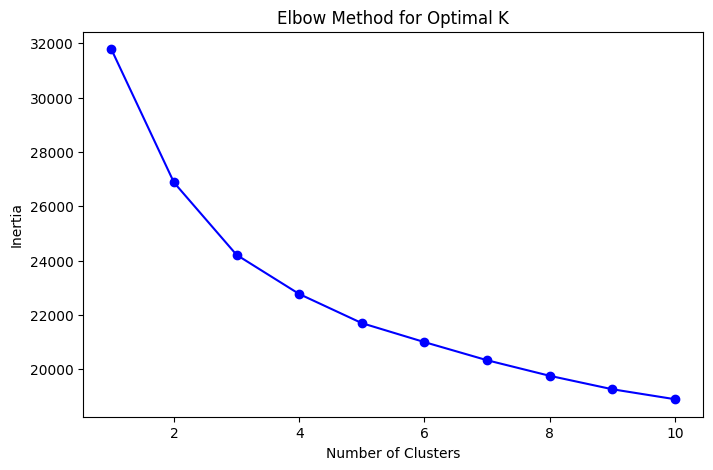

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)  # 1~10개의 클러스터 시도

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

# Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [ ]:
# 클러스터링 실행
kmeans = KMeans(n_clusters=3, random_state=42)  # 클러스터 수는 위 분석 결과로 설정
kmeans.fit(clustering_data_scaled)

# 클러스터 레이블 추가
panch['cluster'] = kmeans.labels_


<ipython-input-97-777d84f0e15d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panch['cluster'] = kmeans.labels_


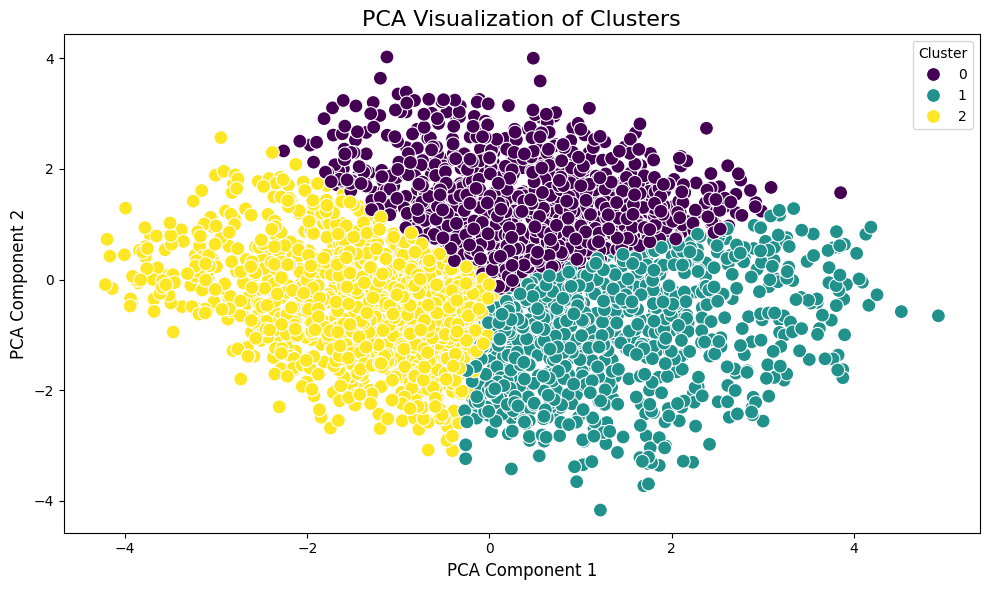

In [ ]:
from sklearn.decomposition import PCA

# PCA로 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_data_scaled)

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c = panch['cluster'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Clusters')
plt.show()


In [ ]:
# 클러스터별 콘텐츠 출석률 평균
cluster_summary = panch.groupby('cluster')[['etc_ratio', 'gomem_ratio', 'mark_ratio',
                                                         'battle_ratio', 'sports_ratio', 'fifa_ratio',
                                                         'song_ratio', 'isegye_ratio', 'asseto_ratio',
                                                         'zomboid_ratio']].mean()

cluster_summary
# panch.groupby('cluster').count()

,etc_ratio,gomem_ratio,mark_ratio,battle_ratio,sports_ratio,fifa_ratio,song_ratio,isegye_ratio,asseto_ratio,zomboid_ratio
cluster,,,,,,,,,,
0,50.658599,51.001694,56.157894,63.031596,57.749089,51.594535,68.530539,57.529383,64.605269,36.101861
1,43.036246,54.896580,47.800442,55.953053,63.040572,61.981025,48.278101,59.439051,31.922255,67.572816
2,41.423553,41.297992,43.507829,48.894902,43.971260,36.096642,54.183976,45.254065,56.929577,23.983740
